## Imports

In [ ]:
# !pip3 install openai==0.27.0 --quiet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import openai
from google.colab import userdata

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import time
import json
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


In [ ]:
DATA_PATH = ""

FA = "2"
PROMPT_PATH = ""
RESULTS_PATH = ""

SEED = 312
N_BOOTSTRAP = 5000

In [ ]:
JUDGE_MODEL = "o3-2025-04-16"
openai.api_key = userdata.get("")

model_ids = [model.id for model in openai.Model.list().data]
assert JUDGE_MODEL in model_ids

## Data

In [ ]:
df = pd.read_csv(DATA_PATH)

df = df[df['assessment'].isin({int(FA)})]
df.drop(columns=['utterance'], inplace=True)
df = df.reset_index(drop=True)

assert not df.isnull().values.any()

assert df['student'].dtype == 'object'
assert df['student'].apply(lambda x: bool(re.fullmatch(r'XYZ25\d{3}', str(x)))).all()
assert df['assessment'].dtype == int
assert set(df['assessment'].unique()) == {int(FA)}
assert df['turn'].dtype == int
assert set(df['turn'])=={1}
assert df['role'].dtype == 'object'
assert set(df['role'])=={'assistant'}
assert df['utterance_clean'].dtype == 'object'
assert df['agent_feedback'].dtype == 'object'
assert df['score'].dtype == 'object'
assert df['score'].str.endswith('/9').all()
assert df['student_response'].dtype == 'object'

df.head()

## Prompt

In [ ]:
with open(PROMPT_PATH, 'r', encoding='utf-8') as f:
    prompt = f.read()

prompt

'You are a learning science researcher whose job it is to determine if a pedagogical agent\'s feedback to students is within that student\'s Zone of Proximal Development (ZPD), as defined by Vygotsky.\n\nPreviously, students were asked the following formative assessment question:\n\n"Write down each rule (recall the IF and THEN multiple choice from today for each category of rainfall)."\n\nThere are three rules the students were required to identify:\n1. If rainfall is less than absorption limit, set absorption to rainfall and set runoff to 0.\n2. If rainfall is equal to absorption limit, set absorption to either rainfall or absorption limit, and set runoff to 0.\n3. If rainfall is greater than absorption limit, set absorption to absorption limit and set runoff to either rainfall - absorption limit or rainfall - absorption.\n\nTheir formative assessment responses were then graded based on the following rubric:\n\nLess Than Condition [0 or 1]: 1 point if the student correctly includes t

## API Call

In [ ]:
def get_openai_response(messages):
  start_time = time.time()
  response = openai.ChatCompletion.create(
      model=JUDGE_MODEL,
      messages=messages,
      response_format={ "type": "json_object" },
      seed=SEED)
  total_time = time.time()-start_time
  total_tokens = response["usage"]["total_tokens"]
  generation = response["choices"][0]["message"]["content"].strip()

  return generation, total_time, total_tokens

In [ ]:
# response = get_openai_response([{"role":"system","content":"Confirm that the api is working. Respond using the following JSON schema: {'working':bool, 'explanation':str}"}])
# print(response)

## Generations

In [ ]:
results = [["messages","generation","total_time_s","total_tokens","summary","explanation","zpd_score"]]

for idx,row in df.iterrows():
    student_str = f"student_response: {row['student_response'].strip()}\n"
    agent_str = f"agent_feedback: {row['agent_feedback'].strip()}\n"
    assessment_score_str = f"assessment_score: {row['score'].strip()}"

    messages = [{"role":"system","content":prompt},{"role":"user","content":student_str+agent_str+assessment_score_str}]

    generation, total_time, total_tokens = get_openai_response(messages)
    parsed_generation = json.loads(generation)

    summary = parsed_generation["summary"]
    explanation = parsed_generation["explanation"]
    zpd_score = parsed_generation["zpd_score"]

    results.append([messages,generation,total_time,total_tokens,summary,explanation,zpd_score])

    print(f"FINISHED CONVERSATION {idx}.")

FINISHED CONVERSATION 0.
FINISHED CONVERSATION 1.
FINISHED CONVERSATION 2.
FINISHED CONVERSATION 3.
FINISHED CONVERSATION 4.
FINISHED CONVERSATION 5.
FINISHED CONVERSATION 6.
FINISHED CONVERSATION 7.
FINISHED CONVERSATION 8.
FINISHED CONVERSATION 9.
FINISHED CONVERSATION 10.
FINISHED CONVERSATION 11.
FINISHED CONVERSATION 12.
FINISHED CONVERSATION 13.
FINISHED CONVERSATION 14.
FINISHED CONVERSATION 15.
FINISHED CONVERSATION 16.
FINISHED CONVERSATION 17.
FINISHED CONVERSATION 18.
FINISHED CONVERSATION 19.
FINISHED CONVERSATION 20.
FINISHED CONVERSATION 21.
FINISHED CONVERSATION 22.
FINISHED CONVERSATION 23.
FINISHED CONVERSATION 24.
FINISHED CONVERSATION 25.
FINISHED CONVERSATION 26.
FINISHED CONVERSATION 27.
FINISHED CONVERSATION 28.
FINISHED CONVERSATION 29.
FINISHED CONVERSATION 30.
FINISHED CONVERSATION 31.
FINISHED CONVERSATION 32.
FINISHED CONVERSATION 33.
FINISHED CONVERSATION 34.
FINISHED CONVERSATION 35.
FINISHED CONVERSATION 36.
FINISHED CONVERSATION 37.
FINISHED CONVERSATION 

## Save

In [ ]:
df_results = pd.DataFrame(results[1:], columns=results[0])
df = pd.concat([df, df_results], axis=1)
df.to_csv(RESULTS_PATH, index=False)

## EDA

In [ ]:
df_results = pd.read_csv(RESULTS_PATH)
df_results = df_results[df_results["assessment"]==int(FA)]
df_results.head()

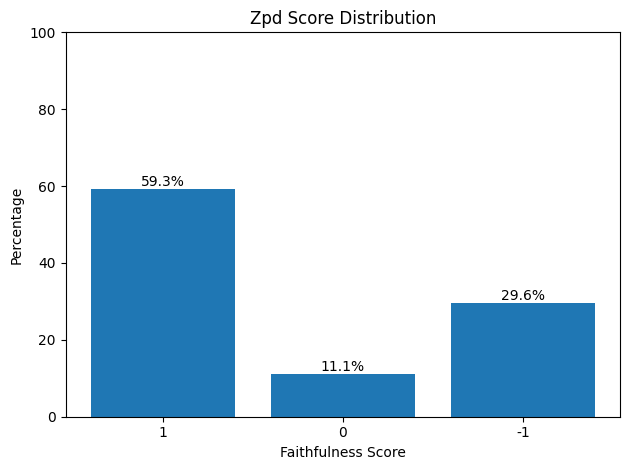

In [4]:
col = "zpd_score"

pct = (
  df_results[col]
  .value_counts(normalize=True)
  .reindex([1, 0, -1], fill_value=0)
  .mul(100)
)

plt.figure()
bars = plt.bar(pct.index.astype(str), pct.values)
plt.title(f"{col.replace('_', ' ').title()} Distribution")
plt.xlabel("Faithfulness Score")
plt.ylabel("Percentage")

for bar, value in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.1f}%",
        ha="center",
        va="bottom",
    )

plt.ylim(0, 100)
plt.tight_layout()

## Confidence Intervals

In [5]:
boot_zpd_yes  = []
boot_zpd_no = []

values = df_results["zpd_score"].to_numpy()

rng = np.random.default_rng(seed=SEED)

for _ in range(N_BOOTSTRAP):
    resample = rng.choice(values, size=len(df_results), replace=True)
    boot_zpd_yes.append((resample ==  1).mean())
    boot_zpd_no.append((resample == -1).mean())

zpd_yes_low,  zpd_yes_high  = np.percentile(boot_zpd_yes,   [2.5, 97.5])
zpd_no_low, zpd_no_high = np.percentile(boot_zpd_no, [2.5, 97.5])

win_moe  = (zpd_yes_high-zpd_yes_low) / 2
loss_moe = (zpd_no_high-zpd_no_low) / 2

p_cons   = (values ==  1).mean()
p_incons = (values == -1).mean()

print(f"ZPD yes (1):    {p_cons*100:.2f} ± {win_moe*100:.2f}  (95 % CI)")
print(f"ZPD no (-1): {p_incons*100:.2f} ± {loss_moe*100:.2f}  (95 % CI)")

ZPD yes (1):    59.26 ± 10.49  (95 % CI)
ZPD no (-1): 29.63 ± 9.88  (95 % CI)
